In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np

class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNetFeatureExtractor, self).__init__()
        self.resnet = models.resnet50(pretrained=True)  # Load ImageNet pre-trained weights

        # Optionally freeze pre-trained layers for initial training
        for param in self.resnet.parameters():
            param.requires_grad = False  # Uncomment to freeze

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x1 = self.resnet.layer1(x)
        x2 = self.resnet.layer2(x1)
        x3 = self.resnet.layer3(x2)
        x4 = self.resnet.layer4(x3)

        return x1, x2, x3, x4


class DecoderNetwork(nn.Module):
    def __init__(self, in_channels=(256, 512, 1024, 2048), out_channels=1):
        super(DecoderNetwork, self).__init__()
        self.up1 = nn.ConvTranspose2d(in_channels[3], in_channels[2], kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels[2] + in_channels[2], in_channels[2], kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels[2])
        self.up2 = nn.ConvTranspose2d(in_channels[2], in_channels[1], kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels[1] + in_channels[1], in_channels[1], kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels[1])
        self.up3 = nn.ConvTranspose2d(in_channels[1], in_channels[0], kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels[0] + in_channels[0], in_channels[0], kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(in_channels[0])
        self.up4 = nn.ConvTranspose2d(in_channels[0], out_channels, kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x1, x2, x3, x4):
        x = F.relu(self.bn1(self.conv1(torch.cat([self.up1(x4), x3], dim=1))))
        x = F.relu(self.bn2(self.conv2(torch.cat([self.up2(x), x2], dim=1))))
        x = F.relu(self.bn3(self.conv3(torch.cat([self.up3(x), x1], dim=1))))
        x = torch.sigmoid(self.conv4(self.up4(x)))
        return x

class ForgeryLocalizationModel(nn.Module):
    def __init__(self):
        super(ForgeryLocalizationModel, self).__init__()
        self.feature_extractor = ResNetFeatureExtractor()
        self.decoder = DecoderNetwork()

    def forward(self, x):
        x1, x2, x3, x4 = self.feature_extractor(x)
        mask = self.decoder(x1, x2, x3, x4)
        return mask

class ForgeryDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.forged_images, self.masked_images = self.load_data(self.dataset_path)

    def __len__(self):
        return len(self.forged_images)

    def __getitem__(self, idx):
        forged_img = self.forged_images[idx]
        masked_img = self.masked_images[idx]
        if self.transform:
            forged_img = self.transform(forged_img)
            masked_img = self.transform(masked_img)
        return forged_img.float(), masked_img.float()

    @staticmethod
    def load_data(dataset_path):
        forged_images = []
        masked_images = []
        target_size = (224, 224)  
        forged_path = os.path.join(dataset_path, 'forged')
        masked_path = os.path.join(dataset_path, 'groundtruth')
        for forged_file, masked_file in zip(os.listdir(forged_path), os.listdir(masked_path)):
            forged_img = cv2.imread(os.path.join(forged_path, forged_file))
            masked_img = cv2.imread(os.path.join(masked_path, masked_file), cv2.IMREAD_GRAYSCALE)
            forged_img = cv2.resize(forged_img, target_size) / 255.0
            masked_img = cv2.resize(masked_img, target_size) / 255.0
            forged_images.append(forged_img)
            masked_images.append(masked_img)
        return np.array(forged_images), np.array(masked_images)
    
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            inputs = inputs.permute(0, 3, 1, 2)  # Transpose input data to match PyTorch format
            outputs = model(inputs)
            # Determine the desired size for interpolation based on the model's output size
            interpolation_size = (outputs.shape[2], outputs.shape[3])
            labels = F.interpolate(labels.unsqueeze(1), size=interpolation_size, mode='nearest')

            labels = labels.squeeze(1)
            labels = labels.view(labels.size(0), -1)  # Flatten labels to match output size
            outputs = outputs.view(outputs.size(0), -1)  # Flatten outputs to match label size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.



# Define transformations
data_transforms = transforms.Compose([transforms.ToTensor()])



In [35]:
# Define dataset and DataLoader
dataset = ForgeryDataset(dataset_path="Casia_F_GT", transform=data_transforms)


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the dataset into training and testing sets
X = dataset.forged_images
y = dataset.masked_images
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

# Define DataLoader for testing set
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)

# Define DataLoader for testing set
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [42]:
# Define the model, criterion, and optimizer
model = ForgeryLocalizationModel()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

<>:39: SyntaxWarning: invalid escape sequence '\S'
<>:39: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Asus\AppData\Local\Temp\ipykernel_22564\2661779257.py:39: SyntaxWarning: invalid escape sequence '\S'
  image_path = 'Casia_F_GT\\forged\Sp_D_CND_A_sec0056_sec0015_0282.jpg'


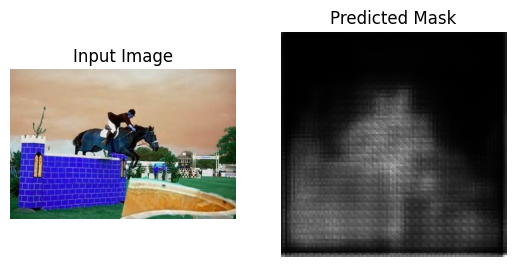

In [56]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

model.eval()

def preprocess_image(image_path):
    # Read the input image
    input_image = cv2.imread(image_path)
    # Resize and normalize the image
    input_image = cv2.resize(input_image, (224, 224)) / 255.0
    # Convert image to PyTorch tensor and add batch dimension
    input_tensor = torch.tensor(input_image.transpose(2, 0, 1)).unsqueeze(0).float()
    return input_tensor

def predict_mask(model, input_image):
    # Perform inference to get the predicted binary mask
    with torch.no_grad():
        predicted_mask = model(input_image)
    return predicted_mask.squeeze().cpu().numpy()

def display_input_and_mask(input_image, predicted_mask):
    # Display the input image
    plt.subplot(1, 2, 1)
    plt.imshow(input_image)
    plt.title('Input Image')
    plt.axis('off')

    # Display the predicted binary mask
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

# Path to the input image
image_path = 'Casia_F_GT\\forged\Sp_D_CND_A_sec0056_sec0015_0282.jpg'

# Preprocess the input image
input_image = preprocess_image(image_path)

# Predict the binary mask
predicted_mask = predict_mask(model, input_image)

# Display the input image and the predicted binary mask
display_input_and_mask(cv2.imread(image_path), predicted_mask)
